In [ ]:
import data
import torch
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from models.test_model import MambaModel
from utils.lightning import LightningMamba
from experiments.sc09_class import get_config
from torch.optim.lr_scheduler import LambdaLR
from utils.utils import set_seed, model_summary, format_time, handle_wandb_login
import wandb
import time

config = get_config()

/media/data/tmpoulionis/miniconda3/envs/mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start_time = time.time()
# Set seed for reproducibility
if config["seed"]:
    set_seed(config["seed"])

# Parse config
MODEL_CONFIG = config["model"]
TRAINER_CONFIG = config["trainer"]
DATASET_CONFIG = config["dataset"]
OPTIMIZER_CONFIG = config["optimizer"]
WANDB_CONFIG = config["wandb"]


In [3]:
# ------- Load Dataset and create DataLoaders -------
data = data.get_dataloaders(**DATASET_CONFIG)
train_loader = data["train_loader"]
val_loader = data["val_loader"]
test_loader = data["test_loader"]
num_classes = data["num_classes"]
if TRAINER_CONFIG["max_epochs"] is not None:
    total_steps = len(train_loader) * TRAINER_CONFIG["max_epochs"]
    if TRAINER_CONFIG["max_steps"] is not None:
        total_steps = min(total_steps, TRAINER_CONFIG["max_steps"])
else:
    try:
        total_steps = TRAINER_CONFIG["max_steps"]
    except: 
        raise ValueError("Either max_steps or max_epochs must be defined.")
    
print(f"  ✓ Dataset: {DATASET_CONFIG['dataset_name']}")
print(f"  ✓ Classes: {data['num_classes']}")
print(f"  ✓ Input shape: {data['input_shape']}")
print(f"  ✓ Features: {data['feature_dim']}")
print(f"  ✓ Sequence Length: {data['sequence_length']}")
    

	 Loading sc09 dataset...
	 Creating DataLoaders...
	 Dataloaders created.
  ✓ Dataset: sc09
  ✓ Classes: 10
  ✓ Input shape: torch.Size([128, 107, 64])
  ✓ Features: 64
  ✓ Sequence Length: 107


In [4]:
# ------- Create Model -------
print("Constructing Model...")
model = MambaModel(**MODEL_CONFIG, d_out=num_classes).cuda()
model_summary(model)

Constructing Model...


Layer (type:depth-idx)                   Param #
MambaModel                               --
├─ModuleList: 1-1                        --
│    └─PhotonicMamba: 2-1                --
│    │    └─Mamba: 3-1                   32,640
├─ModuleList: 1-2                        --
│    └─LayerNorm: 2-2                    128
├─LayerNorm: 1-3                         128
├─Sequential: 1-4                        --
│    └─Linear: 2-3                       8,320
│    └─LayerNorm: 2-4                    256
│    └─GELU: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       1,290
Total params: 42,762
Trainable params: 42,762
Non-trainable params: 0

In [5]:
# ------- W&B Logger -------
print("\n[3/6] Setting up W&B Logger...")
usrname = handle_wandb_login()
wandb_logger = WandbLogger(
    project=WANDB_CONFIG["project"],
    entity=usrname,
    name=WANDB_CONFIG["name"],
    log_model="all",
    save_dir="./wandb_logs"
)

print(f"  ✓ Project:", wandb_logger.experiment.project)
print(f"  ✓ Name:", wandb_logger.experiment.name)
print(f"  ✓ URL:", wandb_logger.experiment.url)


[3/6] Setting up W&B Logger...

--- Weights & Biases (W&B) Configuration ---
W&B username: tmpoulionis-


wandb: Currently logged in as: tmpoulionis (tmpoulionis-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B login successful!


  ✓ Project: lightning_logs
  ✓ Name: splendid-silence-44
  ✓ URL: https://wandb.ai/tmpoulionis-/lightning_logs/runs/n7xq75va


In [7]:
# ------- Callbacks -------
print("\n[4/6] Setting up Callbacks...")

callbacks = [
    LearningRateMonitor(logging_interval='step'),
    ModelCheckpoint(
        dirpath=f"./checkpoints/{wandb_logger.name}",
        filename="best-{epoch:02d}-{val/acc:.4f}",
        monitor="val/acc",
        mode="max",
        save_top_k=1,
        save_last=True
    ),
    EarlyStopping(
        monitor="val/loss",
        patience=20,
        mode="min",
        verbose=True
    )
]

print(f"  ✓ Learning rate monitor")
print(f"  ✓ Model checkpointing (save top 3)")
print(f"  ✓ Early stopping (patience=20)")
    


[4/6] Setting up Callbacks...
  ✓ Learning rate monitor
  ✓ Model checkpointing (save top 3)
  ✓ Early stopping (patience=20)


In [8]:
# ------- Scheduler -------
from train import create_scheduler
warmup_steps = int(0.1 * total_steps)

scheduler_config = {
    "scheduler": create_scheduler,
    "params": {
        "total_steps": total_steps,
        "warmup_steps": warmup_steps
    }
}
    

In [9]:
# ------- Lightning Module -------
print("\n[5/6) Setting up Lightning Module...")
loss_fn = torch.nn.CrossEntropyLoss()

lightning_module = LightningMamba(
    model=model,
    optimizer=torch.optim.AdamW,
    loss_fn=loss_fn,
    opt_hyperparams=OPTIMIZER_CONFIG,
    scheduler_config=scheduler_config
)


[5/6) Setting up Lightning Module...


In [10]:
# ------- Trainer -------
print("\n[6/6] Initializing Trainer...")
trainer = L.Trainer(
    **TRAINER_CONFIG,
    logger=wandb_logger,
    callbacks=callbacks,
)

print(f"  ✓ Max steps: {TRAINER_CONFIG['max_steps'] if TRAINER_CONFIG['max_steps'] else 'N/A'}")
print(f"  ✓ Max epochs: {TRAINER_CONFIG['max_epochs'] if TRAINER_CONFIG['max_epochs'] else 'N/A'}")
print(f"  ✓ Accelerator: {TRAINER_CONFIG['accelerator']}")
print(f"  ✓ Gradient clip: {TRAINER_CONFIG['gradient_clip_val']}")
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



[6/6] Initializing Trainer...
  ✓ Max steps: 200000
  ✓ Max epochs: 30
  ✓ Accelerator: auto
  ✓ Gradient clip: 0.1


In [1]:
from dataloaders.data import get_dataloaders
data = get_dataloaders("sc09")

/media/data/tmpoulionis/miniconda3/envs/mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
data

{'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7fbee55f3490>,
 'valid_loader': <torch.utils.data.dataloader.DataLoader at 0x7fbee55f3040>,
 'test_loader': <torch.utils.data.dataloader.DataLoader at 0x7fbee55f3100>,
 'input_shape': [32, 131071],
 'num_classes': None}

In [2]:
print(len(data['train_loader']))
print(len(data['valid_loader']))
print(len(data['test_loader']))

974
114
129


In [3]:
dataiter = iter(data['train_loader'])

In [4]:
sample = next(dataiter)

In [5]:
sample

[tensor([[[-0.1071, -0.1168, -0.1457,  ..., -0.1460, -0.1460, -0.1460],
          [-0.0752, -0.0927, -0.1454,  ..., -0.1460, -0.1461, -0.1461],
          [-0.0830, -0.0986, -0.1455,  ..., -0.1460, -0.1461, -0.1461],
          ...,
          [-0.1236, -0.1289, -0.1450,  ..., -0.1458, -0.1460, -0.1461],
          [-0.1365, -0.1386, -0.1452,  ..., -0.1460, -0.1461, -0.1461],
          [-0.1194, -0.1257, -0.1444,  ..., -0.1460, -0.1460, -0.1460]],
 
         [[-0.1490, -0.1486, -0.1475,  ..., -0.1492, -0.1492, -0.1492],
          [-0.1467, -0.1470, -0.1480,  ..., -0.1492, -0.1492, -0.1492],
          [-0.1478, -0.1479, -0.1482,  ..., -0.1492, -0.1492, -0.1492],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.0618, -0.0618, -0.0618,  ..., -0.0618, -0.0618, -0.0618],
          [-0.0611, -0.0612,

In [6]:
sample[0][0]

tensor([[-0.1071, -0.1168, -0.1457,  ..., -0.1460, -0.1460, -0.1460],
        [-0.0752, -0.0927, -0.1454,  ..., -0.1460, -0.1461, -0.1461],
        [-0.0830, -0.0986, -0.1455,  ..., -0.1460, -0.1461, -0.1461],
        ...,
        [-0.1236, -0.1289, -0.1450,  ..., -0.1458, -0.1460, -0.1461],
        [-0.1365, -0.1386, -0.1452,  ..., -0.1460, -0.1461, -0.1461],
        [-0.1194, -0.1257, -0.1444,  ..., -0.1460, -0.1460, -0.1460]])

In [13]:
from utils.utils import load_config
from dataloaders.data import get_dataloaders, create_dataset
config = load_config('hg38_gene')


In [23]:
data_config = config["dataset"]
data, _ = create_dataset('hg38')

In [26]:
dataset=data['train']

In [28]:
max_token = -float('inf')
min_token = float('inf')

for x, y in dataset:
    max_token = max(max_token, x.max().item())
    min_token = min(min_token, x.min().item())

print("Max token index in dataset:", max_token)
print("Min token index in dataset:", min_token)

Max token index in dataset: 11
Min token index in dataset: 7


In [5]:
datater = iter(data['train_loader'])
sample = next(datater)

In [9]:
x = sample[0]

In [11]:
len(data['train_loader'])

8506

In [12]:
print(x.max(), x.min())

tensor(10) tensor(7)


In [1]:
import torch
from utils.lightning import LightningMamba
from utils.utils import check_non_negativity, load_config
from models.test_model import MambaModel
from train import create_scheduler

config = load_config('sc09_class')
MODEL_CONFIG = config["model"]

lit_model = LightningMamba.load_from_checkpoint(
    'checkpoints/config3: full/best-epoch=24-val_acc=0.8246.ckpt',
    model=MambaModel(**MODEL_CONFIG, d_out=10),
    optimizer=torch.optim.AdamW,
    loss_fn=torch.nn.CrossEntropyLoss()
)
model = lit_model.model
model.eval()

# for name, params in model.named_parameters():
#     print(name)

/media/data/tmpoulionis/miniconda3/envs/mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MambaModel(
  (mamba_layers): ModuleList(
    (0-1): 2 x PhotonicMamba(
      (mamba): Mamba(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
        (act): PELULike()
        (x_proj): Linear(in_features=128, out_features=36, bias=False)
        (dt_proj): Linear(in_features=4, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=64, bias=False)
      )
      (delta_activation): PELULike()
      (gate_activation): PELULike()
    )
  )
  (layer_norms): ModuleList(
    (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (final_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (head): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): PELULike()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out

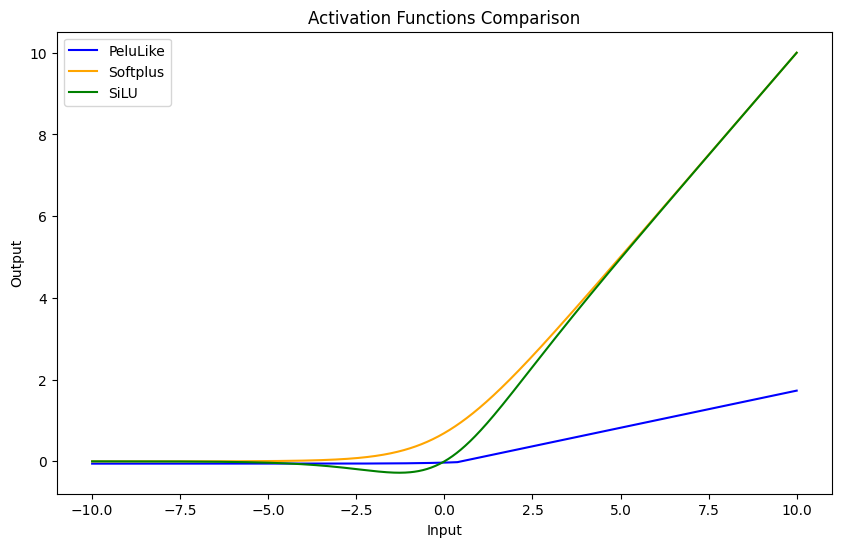

TypeError: softplus(): argument 'input' (position 1) must be Tensor, not int

In [ ]:
from utils.activations import Activation
import numpy as np
import matplotlib.pyplot as plt
import torch

pelulike = Activation('pelulike')
softplus = Activation('softplus')
silu = Activation('silu')

x = torch.linspace(-10, 10, steps=1000)

plt.figure(figsize=(10, 6))
plt.plot(x, pelulike(x), label='PeluLike', color='blue')
plt.plot(x, softplus(x), label='Softplus', color='orange')
plt.plot(x, silu(x), label='SiLU', color='green')
plt.title('Activation Functions Comparison')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()
x = torch.tensor(10.0)
print(softplus(10)/pelulike(10))

In [6]:
import torch
from utils.lightning import LightningMamba
from utils.utils import check_non_negativity, load_config
from models.test_model import MambaModel
from train import create_scheduler

config = load_config('sc09_class')
MODEL_CONFIG = config["model"]

lit_model = LightningMamba.load_from_checkpoint(
    'checkpoints/config3: non-negative hooks set/best-epoch=27-val_acc=0.8199.ckpt',
    model=MambaModel(**MODEL_CONFIG, d_out=10),
    optimizer=torch.optim.AdamW,
    loss_fn=torch.nn.CrossEntropyLoss()
)
model = lit_model.model

# for name, params in model.named_parameters():
#     print(name)

/media/data/tmpoulionis/miniconda3/envs/mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results = check_non_negativity(model, verbose=True)

❌ Parameter 'mamba_layers.0.mamba.A_log
	 32/4096 negative parameters.
	 min: -0.7135604023933411, max: 2.756282329559326
✔️ Parameter 'mamba_layers.0.mamba.D' has no negative values. (128)
❌ Parameter 'mamba_layers.0.mamba.in_proj.weight
	 7880/16384 negative parameters.
	 min: -0.5097499489784241, max: 0.4808487892150879
✔️ Parameter 'mamba_layers.0.mamba.conv1d.weight' has no negative values. (512)
✔️ Parameter 'mamba_layers.0.mamba.conv1d.bias' has no negative values. (128)
✔️ Parameter 'mamba_layers.0.mamba.x_proj.weight' has no negative values. (8704)
❌ Parameter 'mamba_layers.0.mamba.dt_proj.weight
	 253/512 negative parameters.
	 min: -0.3449002206325531, max: 0.3452172577381134
❌ Parameter 'mamba_layers.0.mamba.dt_proj.bias
	 128/128 negative parameters.
	 min: -4.692990779876709, max: -1.5770251750946045
✔️ Parameter 'mamba_layers.0.mamba.out_proj.weight' has no negative values. (8192)
❌ Parameter 'mamba_layers.1.mamba.A_log
	 40/4096 negative parameters.
	 min: -0.7253836393

In [3]:
model.eval()
model.forward(torch.randn(1, 151, 64).to('cuda'))

❌ Parameter u:
	 17606/19328 negative values.
	 min: -0.055377669632434845, max: 0.5635495781898499
❌ Parameter delta:
	 9189/19328 negative values.
	 min: -0.08500553667545319, max: 0.07565196603536606
❌ Parameter delta bias:
	 128/128 negative values.
	 min: -4.692990779876709, max: -1.5770251750946045
❌ Parameter A:
	 4096/4096 negative values.
	 min: -15.74121379852295, max: -0.48989686369895935
❌ Parameter B:
	 4832/4832 negative values.
	 min: -4.344630718231201, max: -0.8375756144523621
❌ Parameter C:
	 4832/4832 negative values.
	 min: -4.50983190536499, max: -0.0507335364818573
✔️ Parameter D has no negative values. (128)
❌ Parameter z:
	 9323/19328 negative values.
	 min: -4.043632984161377, max: 5.731603622436523
❌ Parameter u:
	 17581/19328 negative values.
	 min: -0.05560459941625595, max: 0.7433915138244629
❌ Parameter delta:
	 9131/19328 negative values.
	 min: -0.08074232190847397, max: 0.07772012799978256
❌ Parameter delta bias:
	 128/128 negative values.
	 min: -4.768

tensor([[ 3.5137,  1.2395,  0.5448, -0.1720,  0.4379,  1.1061,  2.6330,  1.2131,
          0.0496, -0.1115]], device='cuda:0', grad_fn=<AddmmBackward0>)